In [1]:
import os
import time
from IPython.display import clear_output

import ale_py
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecFrameStack

In [2]:
### Define custom callbacks that will be used during training (Note: 'previous_interval_avg_reward' tracking variable is currently incorrect) ###

class EpisodeRewardTracker(BaseCallback):
    """Callback to track results and periodically print them during training."""
    def __init__(self, eval_freq):
        super().__init__()
        self.episode_rewards = []
        self.current_episode_reward = 0
        self.eval_freq = eval_freq
        # self.total_steps_completed = 0

    def _on_step(self):
        # self.total_steps_completed += len(self.locals['dones']) # Dependent on number of envs
        self.current_episode_reward += int(self.locals['rewards'][0])

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0
            episode = len(self.episode_rewards)
            
            if episode % self.eval_freq == 0: # Print performance to monitor training
                avg_reward = round(np.mean(self.episode_rewards[episode - self.eval_freq:]))
                epsilon = self.model.exploration_rate
                trial_rewards, trial_lengths = evaluate_policy(
                    self.model,
                    self.training_env,
                    n_eval_episodes=5,
                    return_episode_rewards=True
                )
                print(
                    f'{episode=} | total_steps_completed={self.model.num_timesteps} | {epsilon = :.4f} | '
                    f'previous_interval_avg_reward={avg_reward} | {trial_rewards=} | {trial_lengths=}'
                )

        return True


class ExponentialDecayExploration(BaseCallback):
    """Callback to control the epsilon decay."""
    def __init__(self, initial_eps=1.0, decay_rate=0.995, final_eps=0.01, verbose=0):
        super().__init__(verbose)
        self.initial_eps = initial_eps
        self.decay_rate = decay_rate
        self.final_eps = final_eps

    def _on_step(self) -> bool:
        current_timestep = self.locals["self"].num_timesteps
        self.locals["self"].exploration_rate = max(
            self.final_eps, self.initial_eps * self.decay_rate**current_timestep
        )
        return True

In [3]:
### Model/env definition and training (Note: 'previous_interval_avg_reward' tracking variable is currently incorrect) ###

# Hyperparameters
TOTAL_TIMESTEPS = 5000000
EPISODE_PRINT_INTERVAL = 1000 # Frequency to print training progress
WINDOW_LENGTH = 4
N_ENVS = 8
hyperparameters = {
    'learning_rate': 0.0005,
    'buffer_size': 100000,
    'batch_size': 64,
    'gamma': 0.99,
    'target_update_interval': 5000,
    'exploration_fraction': 0.3,
    'exploration_final_eps': 0.01
}

# INITIAL_EPSILON = 1.0
# EPSILON_DECAY_RATE = 0.99995
# FINAL_EPSILON = 0.05

# Create the Breakout environment with frame stacking
env = make_atari_env('Breakout-v4', n_envs=N_ENVS)
env = VecFrameStack(env, n_stack=WINDOW_LENGTH)
# obv = env.reset() shape is '(n_envs, 84, 84, n_stack)'. Img preprocessing is resize to 84x84 & convert to grayscale.

# Initialize the DQN agent with a CNN policy, create custom callbacks, and train model
model = DQN('CnnPolicy', env, verbose=0, **hyperparameters)
episode_reward_tracker = EpisodeRewardTracker(EPISODE_PRINT_INTERVAL)
# exp_decay_exploration = ExponentialDecayExploration(
#     initial_eps=INITIAL_EPSILON, decay_rate=EPSILON_DECAY_RATE, final_eps=FINAL_EPSILON
# )
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[episode_reward_tracker])

env.close()

episode=1000 | total_steps_completed=81224 | epsilon = 0.9464 | previous_interval_avg_reward=0 | trial_rewards=[4.0, 2.0, 5.0, 3.0, 10.0] | trial_lengths=[417, 282, 473, 363, 654]
episode=2000 | total_steps_completed=174840 | epsilon = 0.8846 | previous_interval_avg_reward=0 | trial_rewards=[4.0, 6.0, 5.0, 13.0, 11.0] | trial_lengths=[392, 537, 425, 730, 781]
episode=3000 | total_steps_completed=275896 | epsilon = 0.8179 | previous_interval_avg_reward=0 | trial_rewards=[3.0, 4.0, 8.0, 10.0, 10.0] | trial_lengths=[368, 400, 570, 714, 737]
episode=4000 | total_steps_completed=381768 | epsilon = 0.7480 | previous_interval_avg_reward=1 | trial_rewards=[4.0, 6.0, 5.0, 14.0, 12.0] | trial_lengths=[457, 524, 397, 900, 793]
episode=5000 | total_steps_completed=498840 | epsilon = 0.6708 | previous_interval_avg_reward=1 | trial_rewards=[7.0, 7.0, 11.0, 11.0, 11.0] | trial_lengths=[533, 538, 768, 718, 808]
episode=6000 | total_steps_completed=629336 | epsilon = 0.5846 | previous_interval_avg_rewa

In [7]:
### Train for longer ###

ADDITIONAL_TIMESTEPS = 5000000

model.exploration_rate = hyperparameters['exploration_final_eps'] # Note: This line didn't work. Epsilon reset to 1.0
model.learn(total_timesteps=ADDITIONAL_TIMESTEPS, callback=[episode_reward_tracker])

episode=21000 | total_steps_completed=89384 | epsilon = 0.9410 | previous_interval_avg_reward=0 | trial_rewards=[12.0, 24.0, 29.0, 0.0, 0.0] | trial_lengths=[760, 1057, 1241, 36068, 36039]
episode=22000 | total_steps_completed=179232 | epsilon = 0.8817 | previous_interval_avg_reward=0 | trial_rewards=[9.0, 9.0, 24.0, 0.0, 0.0] | trial_lengths=[624, 634, 1028, 36013, 36028]
episode=23000 | total_steps_completed=277552 | epsilon = 0.8168 | previous_interval_avg_reward=0 | trial_rewards=[6.0, 12.0, 10.0, 13.0, 20.0] | trial_lengths=[498, 766, 665, 841, 1011]
episode=24000 | total_steps_completed=384984 | epsilon = 0.7459 | previous_interval_avg_reward=1 | trial_rewards=[3.0, 12.0, 12.0, 11.0, 21.0] | trial_lengths=[336, 839, 824, 763, 924]
episode=25000 | total_steps_completed=503632 | epsilon = 0.6676 | previous_interval_avg_reward=1 | trial_rewards=[1.0, 6.0, 7.0, 20.0, 30.0] | trial_lengths=[249, 472, 546, 1087, 1391]
episode=26000 | total_steps_completed=634544 | epsilon = 0.5812 | pr

KeyboardInterrupt: 

Total episodes completed during training = 30563


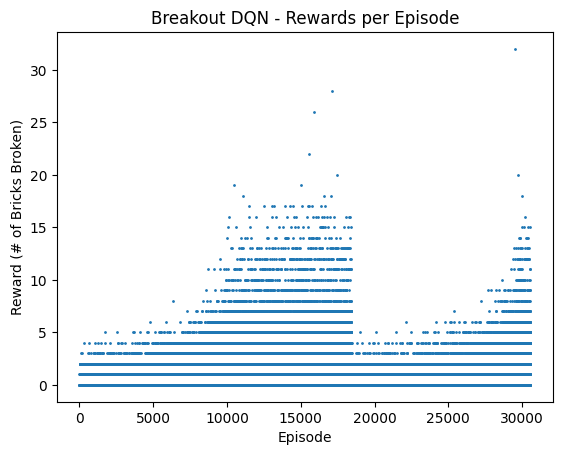

In [10]:
### Plot the episode rewards and training results (with second phase) ###

import matplotlib.pyplot as plt

# Scatter plot of reward for each episode
episodes_completed = len(episode_reward_tracker.episode_rewards)
print(f'Total episodes completed during training = {episodes_completed}')
plt.scatter(range(episodes_completed), episode_reward_tracker.episode_rewards, s=1)
plt.xlabel('Episode')
plt.ylabel('Reward (# of Bricks Broken)')
plt.title('Breakout DQN - Rewards per Episode')
plt.show()

Total episodes completed during training = 18440


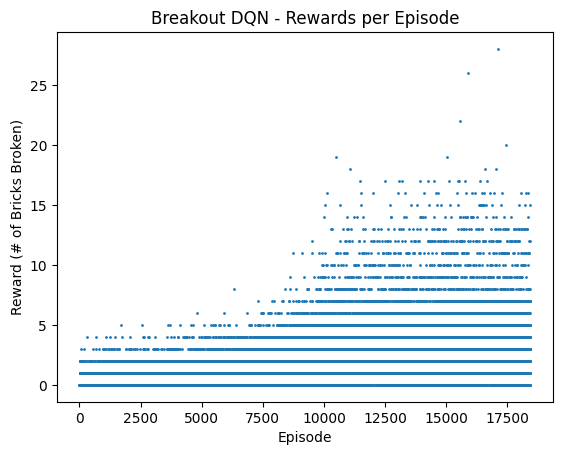

In [4]:
### Plot the episode rewards and training results (first phase of training only) ###

import matplotlib.pyplot as plt

# Scatter plot of reward for each episode
episodes_completed = len(episode_reward_tracker.episode_rewards)
print(f'Total episodes completed during training = {episodes_completed}')
plt.scatter(range(episodes_completed), episode_reward_tracker.episode_rewards, s=1)
plt.xlabel('Episode')
plt.ylabel('Reward (# of Bricks Broken)')
plt.title('Breakout DQN - Rewards per Episode')
plt.show()

In [11]:
### Save the model ###

# Create directory if it DNE yet
save_dir = os.path.join('models')
os.makedirs(save_dir, exist_ok=True)

# Save the model
model_file_name = 'breakout_dqn_7mil_steps.zip'
full_model_path = os.path.join(save_dir, model_file_name)
model.save(full_model_path)
print(f'Model saved to {full_model_path}')

Model saved to models\breakout_dqn_7mil_steps.zip


In [5]:
### Load and test the trained model (run imports cell at beginning of notebook first) ###

# Define trial parameters
NUM_TRIALS = 100
WINDOW_LENGTH = 4 # Same as during training

# Load model
full_model_path = os.path.join('models', 'breakout_dqn_7mil_steps.zip')
env = make_atari_env('Breakout-v4', n_envs=1)
env = VecFrameStack(env, n_stack=WINDOW_LENGTH)
model = DQN.load(full_model_path, env=env)

# Test/evaluate model
trial_rewards, trial_lengths = evaluate_policy(
    model,
    model.get_env(),
    n_eval_episodes=NUM_TRIALS,
    return_episode_rewards=True
)

# Print results and metrics
print(f'{trial_rewards=}')
print(f'{trial_lengths=}')
print(f'Average reward = {(np.mean(trial_rewards)):.0f}')
print(f'Median reward = {np.median(trial_rewards):.0f}')
print(f'Minimum reward = {np.min(trial_rewards):.0f}')
print(f'Maximum reward = {np.max(trial_rewards):.0f}')
print('Note: "Reward" refers to the number of bricks broken.')

trial_rewards=[28.0, 26.0, 19.0, 89.0, 230.0, 24.0, 36.0, 26.0, 34.0, 41.0, 22.0, 21.0, 50.0, 35.0, 19.0, 29.0, 7.0, 193.0, 22.0, 25.0, 33.0, 63.0, 15.0, 41.0, 14.0, 16.0, 42.0, 23.0, 35.0, 21.0, 12.0, 27.0, 28.0, 14.0, 26.0, 19.0, 46.0, 31.0, 21.0, 35.0, 28.0, 34.0, 13.0, 29.0, 14.0, 21.0, 25.0, 8.0, 15.0, 12.0, 32.0, 40.0, 14.0, 38.0, 20.0, 29.0, 28.0, 27.0, 20.0, 30.0, 40.0, 25.0, 61.0, 19.0, 11.0, 21.0, 23.0, 24.0, 41.0, 17.0, 35.0, 32.0, 31.0, 62.0, 42.0, 42.0, 48.0, 27.0, 34.0, 26.0, 21.0, 20.0, 13.0, 29.0, 25.0, 13.0, 16.0, 11.0, 43.0, 10.0, 17.0, 33.0, 32.0, 28.0, 21.0, 42.0, 32.0, 32.0, 31.0, 25.0]
trial_lengths=[1235, 1087, 1049, 2132, 1664, 1178, 1238, 1202, 1422, 1398, 951, 1044, 1603, 1361, 1142, 1310, 551, 1461, 1038, 1173, 1200, 1991, 941, 1375, 810, 943, 1508, 775, 1210, 875, 826, 1143, 1028, 733, 1132, 1077, 1517, 1190, 1014, 1228, 1340, 1366, 850, 1279, 814, 1117, 1255, 577, 896, 773, 1225, 1343, 819, 1162, 949, 1305, 1178, 1119, 1012, 1304, 1627, 921, 1787, 1066, 753

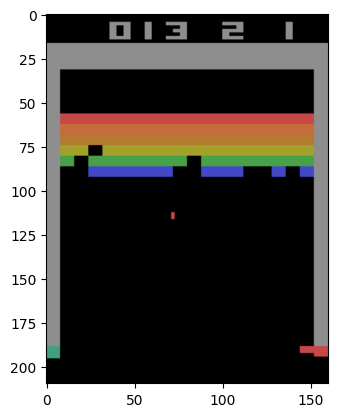

In [14]:
### Visualize the agent (run imports cell at beginning of notebook first) ###

VIZ_DURATION = 200

# Load model and environment
full_model_path = os.path.join('models', 'breakout_dqn_7mil_steps.zip')
env = make_atari_env('Breakout-v4', n_envs=1)
env = VecFrameStack(env, n_stack=4)
model = DQN.load(full_model_path, env=env)

obs = env.reset()
for i in range(VIZ_DURATION):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    img = env.render()
    plt.imshow(img)
    plt.show()
    time.sleep(0.01)
    clear_output(wait=True)
    if done:
        obs = env.reset()
        
env.close()